## VCB

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# Tải dữ liệu (Không có thay đổi)
data = pd.read_csv('../Dataset/VCB.csv')
df = data[['Date','Close']]
df.rename(columns={'Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
df.set_index('Date',inplace=True)
y = df['Price'].values.reshape(-1, 1)

# Chuẩn hóa dữ liệu 
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)

# Chia dữ liệu thành train và test (80/20) 
train_size = int(len(y_norm) * 0.8)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]

# Tạo các chuỗi đầu vào và đầu ra 
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1  # Dự đoán từng bước thời gian
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)

# Xây dựng và huấn luyện mô hình MLP
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(n_lookback,))) # Lớp Dense đầu tiên
model.add(Dense(50, activation='relu'))                            # Lớp Dense ẩn
model.add(Dense(n_forecast))                                       # Lớp Dense đầu ra
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train.reshape(X_train.shape[0], -1), Y_train, epochs=100, batch_size=32, verbose=1)

# Đánh giá trên tập kiểm tra 
Y_pred_test = model.predict(X_test.reshape(X_test.shape[0], -1))
Y_pred_test = scaler.inverse_transform(Y_pred_test)

# Reshape Y_test before inverse transforming
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))  # Reshape to 2D

# Dự đoán tương lai 
last_sequence = y_norm[-n_lookback:].reshape(1, -1)
future_predictions = []
for i in range(90):
    next_pred = model.predict(last_sequence)
    future_predictions.append(next_pred)
    last_sequence = np.concatenate([last_sequence[:, 1:], next_pred], axis=1)  
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

Epoch 1/100


c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0275  
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0011
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.2393e-04
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.3668e-04
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.6270e-04
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.9355e-04
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.5705e-04
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.3597e-04
Epoch 9/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.2353e-04
Epoch 10/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.1639e-04
Epoch 11/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.1222e-04
Epoch 12/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.0157e-04
Epoch 13/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.9040e-04
Epoch 14/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.8409e-04
Epoch 15/100
57/57 ━━━━━━━━━━━━━━

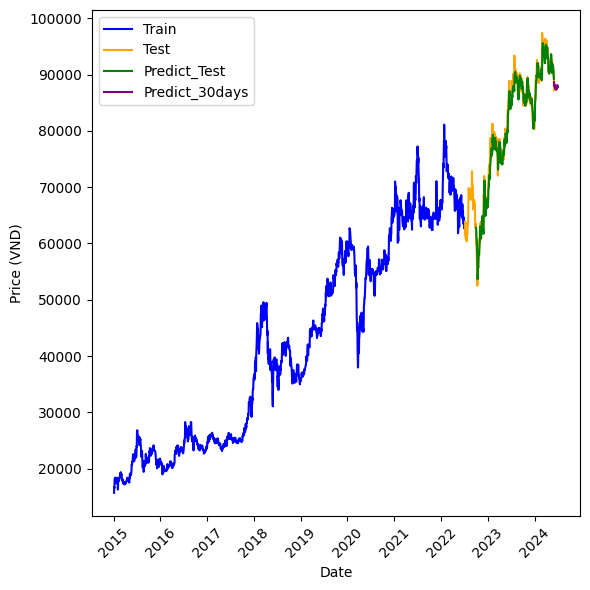

In [2]:
# Trực quan hóa
plt.figure(figsize=(6, 6))

# Vẽ giá thực tế (Tất cả dữ liệu)
plt.plot(df.index[:train_size], df['Price'][:train_size], label='Train', color='blue')

plt.plot(df.index[train_size:], df['Price'][train_size:], label='Test', color='orange')

# Vẽ giá dự đoán trên tập kiểm tra
test_data_start = df.index[train_size + n_lookback]  
test_data_end = df.index[-1]
plt.plot(df.index[train_size + n_lookback: len(Y_pred_test) + train_size + n_lookback], Y_pred_test, label='Predict_Test', color='green')


# Vẽ giá dự đoán trong tương lai
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:]  # Ngày bắt đầu sau ngày cuối cùng của dữ liệu
plt.plot(future_dates[:30], future_predictions[:30], label='Predict_30days', color='purple')
# plt.plot(future_dates[:60], future_predictions[:60], label='Predict_60days', color='red')
# plt.plot(future_dates, future_predictions, label='Predict_90days', color='purple')

# plt.title('VCB Stock Price Forecast using MLP 9:1')
plt.xlabel('Date')
plt.ylabel('Price (VND)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [3]:
# Tạo dataframe mới chứa ngày tháng và giá trị dự đoán tương lai
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:] # Bắt đầu từ ngày sau ngày cuối cùng trong dữ liệu lịch sử
future_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_predictions.flatten()}) # Chuyển future_predictions về mảng 1 chiều
future_df.set_index('Date', inplace=True)

# In ra kết quả dự báo trong 90 ngày tới
print("Dự báo giá cổ phiếu VCB trong 90 ngày tới:")
print(future_df)


Dự báo giá cổ phiếu VCB trong 90 ngày tới:
                Forecast
Date                    
2024-06-01  88666.492188
2024-06-02  88176.484375
2024-06-03  87916.914062
2024-06-04  87927.039062
2024-06-05  88022.781250
...                  ...
2024-08-25  87932.421875
2024-08-26  87901.242188
2024-08-27  87932.882812
2024-08-28  87931.906250
2024-08-29  87843.531250

[90 rows x 1 columns]


In [4]:
# Tính RMSE, MAPE, và MDA trên tập test
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mda = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mda

rmse, mape, mda = calculate_metrics(Y_test, Y_pred_test)

print('RMSE:', rmse)
print('MAPE:', mape, '%')
print('MDA:', mda)

RMSE: 1507.0867753300029
MAPE: 1.403105326628442 %
MDA: 1109.299565333946


## CTG

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# Tải dữ liệu (Không có thay đổi)
data = pd.read_csv('../Dataset/CTG.csv')
df = data[['Date','Close']]
df.rename(columns={'Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
df.set_index('Date',inplace=True)
y = df['Price'].values.reshape(-1, 1)

# Chuẩn hóa dữ liệu 
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)

# Chia dữ liệu thành train và test (80/20) 
train_size = int(len(y_norm) * 0.8)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]

# Tạo các chuỗi đầu vào và đầu ra 
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1  # Dự đoán từng bước thời gian
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)

# Xây dựng và huấn luyện mô hình MLP
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(n_lookback,))) # Lớp Dense đầu tiên
model.add(Dense(50, activation='relu'))                            # Lớp Dense ẩn
model.add(Dense(n_forecast))                                       # Lớp Dense đầu ra
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train.reshape(X_train.shape[0], -1), Y_train, epochs=100, batch_size=32, verbose=1)

# Đánh giá trên tập kiểm tra 
Y_pred_test = model.predict(X_test.reshape(X_test.shape[0], -1))
Y_pred_test = scaler.inverse_transform(Y_pred_test)

# Reshape Y_test before inverse transforming
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))  # Reshape to 2D

# Dự đoán tương lai 
last_sequence = y_norm[-n_lookback:].reshape(1, -1)
future_predictions = []
for i in range(90):
    next_pred = model.predict(last_sequence)
    future_predictions.append(next_pred)
    last_sequence = np.concatenate([last_sequence[:, 1:], next_pred], axis=1)  
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

Epoch 1/100


c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0108  
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0017
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0010    
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.8284e-04
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.0606e-04
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.1398e-04
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.1017e-04
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.7529e-04
Epoch 9/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.7295e-04
Epoch 10/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.7440e-04
Epoch 11/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.6110e-04
Epoch 12/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.5275e-04
Epoch 13/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.4175e-04
Epoch 14/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.1440e-04
Epoch 15/100
57/57 ━━━━━━━━━━━━━━

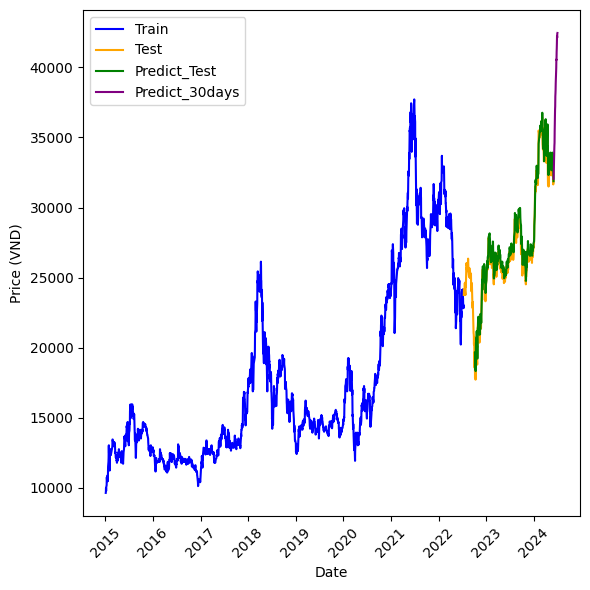

In [6]:
# Trực quan hóa
plt.figure(figsize=(6, 6))

# Vẽ giá thực tế (Tất cả dữ liệu)
plt.plot(df.index[:train_size], df['Price'][:train_size], label='Train', color='blue')

plt.plot(df.index[train_size:], df['Price'][train_size:], label='Test', color='orange')

# Vẽ giá dự đoán trên tập kiểm tra
test_data_start = df.index[train_size + n_lookback]  
test_data_end = df.index[-1]
plt.plot(df.index[train_size + n_lookback: len(Y_pred_test) + train_size + n_lookback], Y_pred_test, label='Predict_Test', color='green')


# Vẽ giá dự đoán trong tương lai
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:]  # Ngày bắt đầu sau ngày cuối cùng của dữ liệu
plt.plot(future_dates[:30], future_predictions[:30], label='Predict_30days', color='purple')
# plt.plot(future_dates[:60], future_predictions[:60], label='Predict_60days', color='red')
# plt.plot(future_dates, future_predictions, label='Predict_90days', color='purple')

# plt.title('CTG Stock Price Forecast using MLP 9:1')
plt.xlabel('Date')
plt.ylabel('Price (VND)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
# Tạo dataframe mới chứa ngày tháng và giá trị dự đoán tương lai
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:] # Bắt đầu từ ngày sau ngày cuối cùng trong dữ liệu lịch sử
future_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_predictions.flatten()}) # Chuyển future_predictions về mảng 1 chiều
future_df.set_index('Date', inplace=True)

# In ra kết quả dự báo trong 90 ngày tới
print("Dự báo giá cổ phiếu CTG trong 90 ngày tới:")
print(future_df)


Dự báo giá cổ phiếu CTG trong 90 ngày tới:
                Forecast
Date                    
2024-06-01  32053.437500
2024-06-02  32478.789062
2024-06-03  32852.976562
2024-06-04  33331.941406
2024-06-05  33716.621094
...                  ...
2024-08-25  52912.769531
2024-08-26  53272.941406
2024-08-27  53601.656250
2024-08-28  53911.824219
2024-08-29  54252.277344

[90 rows x 1 columns]


In [8]:
# Tính RMSE, MAPE, và MDA trên tập test
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mda = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mda

rmse, mape, mda = calculate_metrics(Y_test, Y_pred_test)

print('RMSE:', rmse)
print('MAPE:', mape, '%')
print('MDA:', mda)

RMSE: 654.3624435198118
MAPE: 1.9197013532915537 %
MDA: 518.1065766350856


## BID

In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
tf.random.set_seed(0)

# Tải dữ liệu (Không có thay đổi)
data = pd.read_csv('../Dataset/BID.csv')
df = data[['Date','Close']]
df.rename(columns={'Close': 'Price'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date',inplace=True)
df.set_index('Date',inplace=True)
y = df['Price'].values.reshape(-1, 1)

# Chuẩn hóa dữ liệu 
scaler = MinMaxScaler(feature_range=(0, 1))
y_norm = scaler.fit_transform(y)

# Chia dữ liệu thành train và test (80/20) 
train_size = int(len(y_norm) * 0.8)
y_train, y_test = y_norm[:train_size], y_norm[train_size:]

# Tạo các chuỗi đầu vào và đầu ra 
def create_sequences(data, n_lookback, n_forecast):
    X, Y = [], []
    for i in range(n_lookback, len(data) - n_forecast + 1):
        X.append(data[i - n_lookback: i])
        Y.append(data[i: i + n_forecast])
    return np.array(X), np.array(Y)

n_lookback = 60
n_forecast = 1  # Dự đoán từng bước thời gian
X_train, Y_train = create_sequences(y_train, n_lookback, n_forecast)
X_test, Y_test = create_sequences(y_test, n_lookback, n_forecast)

# Xây dựng và huấn luyện mô hình MLP
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(n_lookback,))) # Lớp Dense đầu tiên
model.add(Dense(50, activation='relu'))                            # Lớp Dense ẩn
model.add(Dense(n_forecast))                                       # Lớp Dense đầu ra
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train.reshape(X_train.shape[0], -1), Y_train, epochs=100, batch_size=32, verbose=1)

# Đánh giá trên tập kiểm tra 
Y_pred_test = model.predict(X_test.reshape(X_test.shape[0], -1))
Y_pred_test = scaler.inverse_transform(Y_pred_test)

# Reshape Y_test before inverse transforming
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))  # Reshape to 2D

# Dự đoán tương lai 
last_sequence = y_norm[-n_lookback:].reshape(1, -1)
future_predictions = []
for i in range(90):
    next_pred = model.predict(last_sequence)
    future_predictions.append(next_pred)
    last_sequence = np.concatenate([last_sequence[:, 1:], next_pred], axis=1)  
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

Epoch 1/100


c:\Users\ngoct\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0381
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011    
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.6253e-04
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.3152e-04
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.1956e-04
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.6170e-04
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8885e-04
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3974e-04
Epoch 9/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1467e-04
Epoch 10/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0697e-04
Epoch 11/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0316e-04
Epoch 12/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0411e-04
Epoch 13/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0324e-04
Epoch 14/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0194e-04
Epoch 15/100
57/57 ━━━━━━━━━━━━

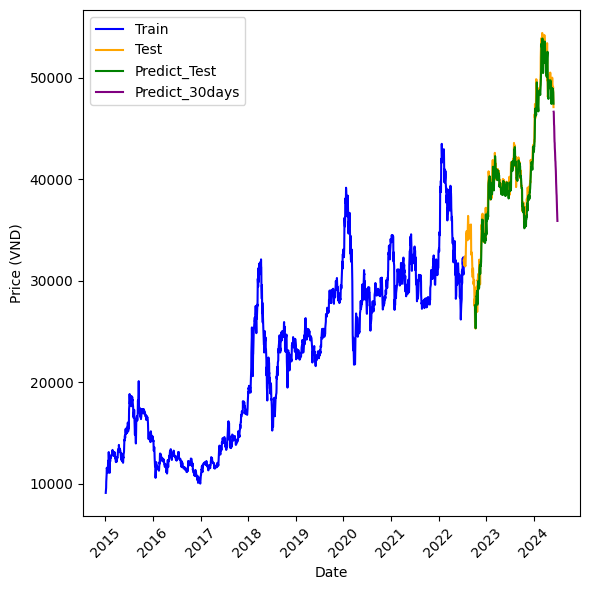

In [10]:
# Trực quan hóa
plt.figure(figsize=(6, 6))

# Vẽ giá thực tế (Tất cả dữ liệu)
plt.plot(df.index[:train_size], df['Price'][:train_size], label='Train', color='blue')

plt.plot(df.index[train_size:], df['Price'][train_size:], label='Test', color='orange')

# Vẽ giá dự đoán trên tập kiểm tra
test_data_start = df.index[train_size + n_lookback]  
test_data_end = df.index[-1]
plt.plot(df.index[train_size + n_lookback: len(Y_pred_test) + train_size + n_lookback], Y_pred_test, label='Predict_Test', color='green')


# Vẽ giá dự đoán trong tương lai
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:]  # Ngày bắt đầu sau ngày cuối cùng của dữ liệu
plt.plot(future_dates[:30], future_predictions[:30], label='Predict_30days', color='purple')
# plt.plot(future_dates[:60], future_predictions[:60], label='Predict_60days', color='red')
# plt.plot(future_dates, future_predictions, label='Predict_90days', color='purple')

# plt.title('BID Stock Price Forecast using MLP 9:1')
plt.xlabel('Date')
plt.ylabel('Price (VND)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
# Tạo dataframe mới chứa ngày tháng và giá trị dự đoán tương lai
future_dates = pd.date_range(start=df.index[-1], periods=91)[1:] # Bắt đầu từ ngày sau ngày cuối cùng trong dữ liệu lịch sử
future_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_predictions.flatten()}) # Chuyển future_predictions về mảng 1 chiều
future_df.set_index('Date', inplace=True)

# In ra kết quả dự báo trong 90 ngày tới
print("Dự báo giá cổ phiếu BID trong 90 ngày tới:")
print(future_df)


Dự báo giá cổ phiếu BID trong 90 ngày tới:
                Forecast
Date                    
2024-06-01  46649.125000
2024-06-02  46593.277344
2024-06-03  46024.984375
2024-06-04  45410.433594
2024-06-05  45257.578125
...                  ...
2024-08-25  29739.472656
2024-08-26  29736.837891
2024-08-27  29774.718750
2024-08-28  29800.960938
2024-08-29  29778.048828

[90 rows x 1 columns]


In [12]:
# Tính RMSE, MAPE, và MDA trên tập test
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    mda = mean_absolute_error(y_true, y_pred)
    return rmse, mape, mda

rmse, mape, mda = calculate_metrics(Y_test, Y_pred_test)

print('RMSE:', rmse)
print('MAPE:', mape, '%')
print('MDA:', mda)

RMSE: 922.743488224837
MAPE: 1.6723260793397219 %
MDA: 670.8460756036063
